In [3]:

import pandas as pd
import numpy as np
import os, sys
import plotly.express as px
import h5py
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy import stats
# pvlib imports
import pvlib
from pvlib.irradiance import complete_irradiance



import zipfile
import requests

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame


In [4]:

# Set working directory
os.chdir(r"..") # should be the git repo root directory
print("Current working directory: " + os.getcwd())
repo_name = 'net-load-forecasting'
assert os.getcwd()[-len(repo_name):] == "net-load-forecasting", "Working directory is not the git repo root directory"

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\net-load-forecasting


In [5]:
# Setting up data paths and folder structure

raw_data_path = os.path.join(os.getcwd(),'data','raw_data')
if not os.path.exists(raw_data_path):
    os.makedirs(raw_data_path)
    print("Created directory: " + raw_data_path)

raw_data_subfolders = ['load', 'pv', 'weather', 'imbalance']

for subfolder in raw_data_subfolders:
    subfolder_path = os.path.join(raw_data_path, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
        print("Created directory: " + subfolder_path)

clean_data_path = os.path.join(os.getcwd(),'data','clean_data')
if not os.path.exists(clean_data_path):
    os.makedirs(clean_data_path)
    print("Created directory: " + clean_data_path)




In [6]:
# Import custom functions
from utils.utils import *

# Data Imports & Cleaning for the Project 

## &#x2460; Energy Community Load Data - Germany

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.5642902.svg)](https://doi.org/10.5281/zenodo.5642902) 

Note: Due to their size we have not included the datasets in the repo, but the above link will allow you to download them, np.

We have downloaded the load data for [2018,2019,2020] in [1 minute*, 15 minutes] resolution:

* 2018_data_1min.zip, 2019_data_1min.zip, 2020_data_1min.zip
* 2018_data_15min.zip, 2019_data_15min.zip, 2020_data_15min.zip,

The goal here is to import them, select the useful data, impute missing data where plausible and aggregate to one community for both temporal resolutions

In [83]:
#h5py extraction
resolutions = [
                '1min',
                '15min']

community_members = [ # these are the households with reliable data for the considered duration
            'SFH3', 'SFH4', 'SFH5', 'SFH9', 'SFH10',
            'SFH12', 'SFH16','SFH18','SFH19', 'SFH21',
            'SFH22', 'SFH23', 'SFH27', 'SFH28', 'SFH29',
            'SFH30', 'SFH31','SFH32', 'SFH36', 'SFH38'
            ]



In [ ]:

df_load_per_resolution = {}
store = pd.HDFStore(os.path.join(clean_data_path, "df_load_per_resolution.h5"))

for resolution in resolutions:

    dfs_load = []
    for year in [2018,2019, 2020]:

        with zipfile.ZipFile(f"data/raw_data/load/{year}_data_{resolution}.zip") as zip_file:

            hdf5_file = zip_file.open(f"{year}_data_{resolution}.hdf5")

            f = h5py.File(hdf5_file)
            group_no_pv = f["NO_PV"] #Only regard those profiles that are not mixed with PV generation
            dfs = {}
       
            for member in community_members:
                table = f["NO_PV"][member]["HOUSEHOLD"]["table"][:]
                df = pd.DataFrame(table).dropna().set_index("index")[["P_TOT"]]
                df.index = pd.to_datetime(df.index, unit = "s")
                dfs[member] = df
                break

            df_load = pd.concat(dfs, axis=1)
            dfs_load.append(df_load)

    df_load_individual_households = pd.concat(dfs_load, axis=0)
    df_load_total = df_load_individual_households.sum(axis=1).to_frame('community_load')
    df_load_per_resolution[resolution] = df_load_total
    store.put(f'{resolution}/community_load', df_load_total, format='table')
    store.put(f'{resolution}/community_load', df_load_total, format='table')

store.close()   

In [47]:
df_load_1min = pd.read_hdf(os.path.join(clean_data_path, "df_load_per_resolution.h5"), key='1min/data')
df_load_15min = pd.read_hdf(os.path.join(clean_data_path, "df_load_per_resolution.h5"), key='15min/data')

## &#x2461; PV Power Data - Netherlands

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6906504.svg)](https://doi.org/10.5281/zenodo.6906504)

We have downloaded the 'filtered_pv_power_measurements_ac.csv' file

Note: While meta data is available for download, exact locations of individual PV systems are not included. Since one of the key research questions of this project is to investigate the impact of using exact locations in modeling, we recieved special permission to use the longitude and latitude of PV systems. Unfortunately we cannot share these here. The rest of the code is provided to calculate the locations from the bounding box locations provided in the open-source 'metadata.csv', however. 

Note: Due to their size we have not included the datasets in the repo, but the above link will allow you to download them, and execute the notebook as long as the paths are adjusted.

### Power Data

In [20]:
df_pv = pd.read_csv(os.path.join(os.getcwd(), 'data', 'raw_data', 'pv', 'filtered_pv_power_measurements_ac.csv'), index_col=0, parse_dates=True)

df_pv.head()

,ID001,ID002,ID003,ID004,ID005,ID006,ID007,ID008,ID009,ID010,...,ID166,ID167,ID168,ID169,ID170,ID171,ID172,ID173,ID174,ID175
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-01-01 00:01:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-01-01 00:02:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-01-01 00:03:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-01-01 00:04:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [ ]:
# We only need about 1.5 years of data, so lets visualize the data to see if there are periods of many consecutive NaNs
px.line(df_pv.resample('4H').mean())

In [22]:
# We can see that we can use the first 1.5 years of data, so lets filter the data
df_pv_filtered_1 = df_pv.loc[:'2016-01-01']

In [23]:
df_pv_filtered_2 = df_pv_filtered_1.dropna(thresh=0.9*len(df_pv_filtered_1), axis=1) # Now lets drop the columns with more than 10% NaNs

df_pv_filtered_2.head()   

# 27 Systems remain which is enough for our purposes (since we have 20 households in the community)

# lets further select the ones with the least nan values to match the number of households

,ID002,ID003,ID007,ID008,ID025,ID026,ID028,ID032,ID041,ID042,...,ID095,ID096,ID098,ID100,ID104,ID116,ID125,ID137,ID139,ID142
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 00:01:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 00:02:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 00:03:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-01 00:04:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
len(community_members)

20

In [24]:
df_pv_filtered_2.to_csv(os.path.join(raw_data_path, 'pv', 'filtered_pv_power_measurements_ac_2.csv'))

### Meta Data

In [26]:
df_meta = pd.read_csv(os.path.join(raw_data_path, 'pv', 'metadata.csv'), sep=';')

df_meta['latitude'] = (df_meta['north'] + df_meta['south']) / 2
df_meta['longitude'] = (df_meta['east'] + df_meta['west']) / 2

df_meta = df_meta[['ID', 'latitude', 'longitude', 'tilt', 'azimuth', 'estimated_dc_capacity', 'estimated_ac_capacity']]

# select those systems that are in the filtered data

df_meta_filtered = df_meta[df_meta['ID'].isin(df_pv_filtered_2.columns)]


df_meta_filtered.to_csv(os.path.join(raw_data_path, 'pv', 'metadata_with_lat_lng.csv'), index=False)



<Figure size 1000x1000 with 0 Axes>

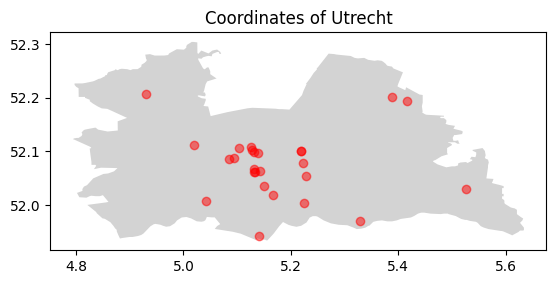

In [27]:

# Lets visualize the coordinates of the PV systems on a map

# Read the shapefile of the Netherlands
netherlands = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")

# Select the city of Utrecht
utrecht = netherlands.iloc[[10]]

# Create a dataframe of the coordinates
df_coords = df_meta_filtered[['ID','latitude','longitude']].copy()
df_coords.set_index('ID', inplace=True)

# Create a list of points from the coordinates
geometry = [Point(xy) for xy in zip(df_coords['longitude'], df_coords['latitude'])]

# Create a GeoDataFrame from the coordinates
gdf = GeoDataFrame(df_coords, geometry=geometry)

# Plot the map of the Netherlands
plt.figure(figsize=(10, 10))
ax = utrecht.plot(color='lightgray')

# Plot the coordinates on the map
gdf.plot(ax=ax, color='red', marker='o', alpha=0.5)

# Add a title to the plot
plt.title('Coordinates of Utrecht')
# Show the plot
plt.show()

## &#x2462; Irradiance Data - Netherlands

Here we will use https://open-meteo.com/en/docs to get the relevant weather data.

In the paper we used historic forecast data from https://solcast.com/, which requires an account.


Note: We are using the central coordinates of all systems to get weather data for the general area.


In [51]:
lat_avg = df_meta['latitude'].mean()
lng_avg = df_meta['longitude'].mean()
start_date = df_pv_filtered_2.index[0].strftime('%Y-%m-%d')
end_date = df_pv_filtered_2.index[-1].strftime('%Y-%m-%d')
variables =  ['temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'direct_radiation']
df_weather = get_weather_data(lat_avg, lng_avg, start_date, end_date, variables)

from pvlib.location import Location

location = Location(lat_avg, lng_avg, altitude=0, name='Utrecht')

sol_pos = location.get_solarposition(df_weather.index)

df_irr = complete_irradiance(sol_pos['zenith'], dni = df_weather['direct_normal_irradiance'], dhi= df_weather['diffuse_radiation'], ghi=None)


df_weather.columns = ['temperature', 'dni', 'dhi', 'ghi']

df_weather

,temperature,dni,dhi,ghi
time,,,,
2014-01-01T00:00,5.8,0.0,0.0,0.0
2014-01-01T01:00,6.0,0.0,0.0,0.0
2014-01-01T02:00,6.2,0.0,0.0,0.0
2014-01-01T03:00,6.3,0.0,0.0,0.0
2014-01-01T04:00,5.7,0.0,0.0,0.0
...,...,...,...,...
2016-01-01T19:00,6.0,0.0,0.0,0.0
2016-01-01T20:00,5.8,0.0,0.0,0.0
2016-01-01T21:00,5.7,0.0,0.0,0.0


In [52]:
df_weather.to_csv(os.path.join(raw_data_path, 'weather', 'weather_data_open-meteo.csv'))




## &#x2463; Imbalance Price Data - Netherlands

We source the imbalance settlement price data from TenneT, the Dutch TSO: https://www.tennet.org/english/operational_management/export_data.aspx

:heavy_check_mark: Imbalance Price


In [54]:

df_imb = pd.read_csv(os.path.join(raw_data_path, 'imbalance', 'export.csv'), index_col=0)

df_imb= df_imb.drop(columns=['upward_incident_reserve', 'downward_incident_reserve', 'To regulate up','To regulate down','Incentive component'])
datetime=pd.to_datetime(df_imb.index + ' ' + df_imb['period_until'], format='%m/%d/%Y %H:%M')
df_imb.set_index(datetime, inplace=True)
df_imb.drop(columns=['PTE', 'period_from', 'period_until'], inplace = True)
df_imb.index = pd.to_datetime(df_imb.index)

df_imb.to_csv(os.path.join(raw_data_path, 'imbalance', 'imbalance_prices.csv'))

# Data Merging & Saving 

In [89]:
# importing / loading data

# community load in 1min and 15min resolution
df_load_1min = pd.read_hdf(os.path.join(clean_data_path, "df_load_per_resolution.h5"), key='1min/data').tz_localize('UTC')
df_load_15min = pd.read_hdf(os.path.join(clean_data_path, "df_load_per_resolution.h5"), key='15min/data').tz_localize('UTC')

#pv: power and meta, in 1min and 15min resolution
df_pv = pd.read_csv(os.path.join(raw_data_path, 'pv', 'filtered_pv_power_measurements_ac_2.csv'), index_col=0, parse_dates=True)
df_meta = pd.read_csv(os.path.join(raw_data_path, 'pv', 'metadata_with_lat_lng.csv'))



# weather data in 15 min resolution
df_weather = pd.read_csv(os.path.join(raw_data_path, 'weather', 'weather_data_solcast.csv'), index_col=0, parse_dates=True).tz_localize('UTC')

# imbalance data in 15min resolution
df_imb = pd.read_csv(os.path.join(raw_data_path, 'imbalance', 'imbalance_prices.csv'), index_col=0, parse_dates=True).tz_localize('UTC')


In [86]:
df_load_1min.index = df_load_1min.index - pd.DateOffset(years=4)

In [87]:
df_load_1min_reindexed = df_load_1min.reindex(df_pv.index)
df_netload_1min = pd.concat([df_load_1min_reindexed, df_pv.sum(axis=1).to_frame('community_pv')], axis=1)
df_netload_1min['netload'] = df_netload_1min['total_load'] - df_netload_1min['community_pv']

df_netload_1min.dropna(inplace=True)


In [88]:
px.line(df_netload_1min.resample('1D').mean())

In [58]:
resolutions = ['1min', '15min']
pd.HDFStore(os.path.join(clean_data_path, "data_net_load_forecasting.h5"))

for resolution in resolutions:

    







,dhi,dni,ghi
PeriodStart,,,
2014-12-31 00:00:00,0.0,0.0,0.0
2014-12-31 00:15:00,0.0,0.0,0.0
2014-12-31 00:30:00,0.0,0.0,0.0
2014-12-31 00:45:00,0.0,0.0,0.0
2014-12-31 01:00:00,0.0,0.0,0.0
